In [7]:
import pandas as pd
import networkx as nx
data = pd.read_csv("payments.csv")
num_nodes = data['Sender'].nunique() + data['Receiver'].nunique()
print("Number of nodes:", num_nodes)
num_edges = len(data)
print("Number of edges:", num_edges)
# Create a directed graph from sender-receiver relationships
G = nx.from_pandas_edgelist(data, source='Sender', target='Receiver', create_using=nx.DiGraph())
avg_clustering_coefficient = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering_coefficient)
sender_counts = data['Sender'].value_counts()
receiver_counts = data['Receiver'].value_counts()
max_node_degree = max(sender_counts.max(), receiver_counts.max())
print("Maximum node degree:", max_node_degree)

Number of nodes: 1074
Number of edges: 130535
Average clustering coefficient: 0.12490437175151636
Maximum node degree: 6591


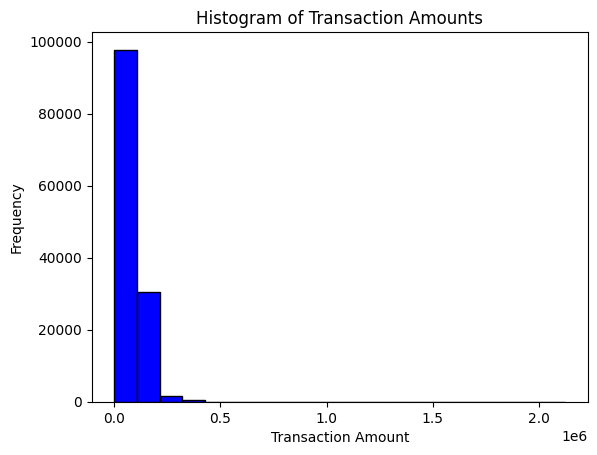

In [11]:
import matplotlib.pyplot as plt
# Plot histogram of transaction amounts
plt.hist(data['Amount'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amounts')
plt.show()


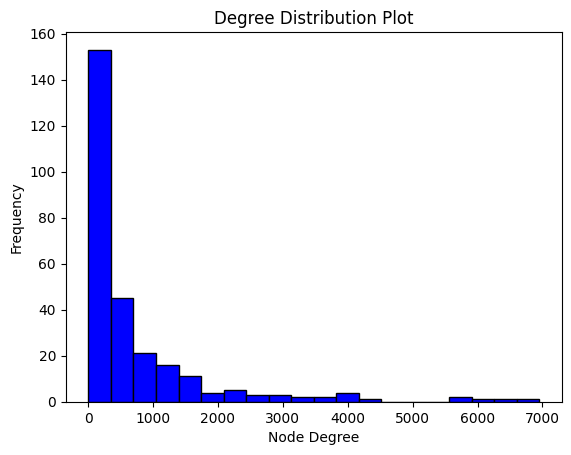

In [12]:
# Calculate node degrees
node_degrees = data['Sender'].value_counts() + data['Receiver'].value_counts()
plt.hist(node_degrees, bins=20, color='blue', edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Plot')
plt.show()


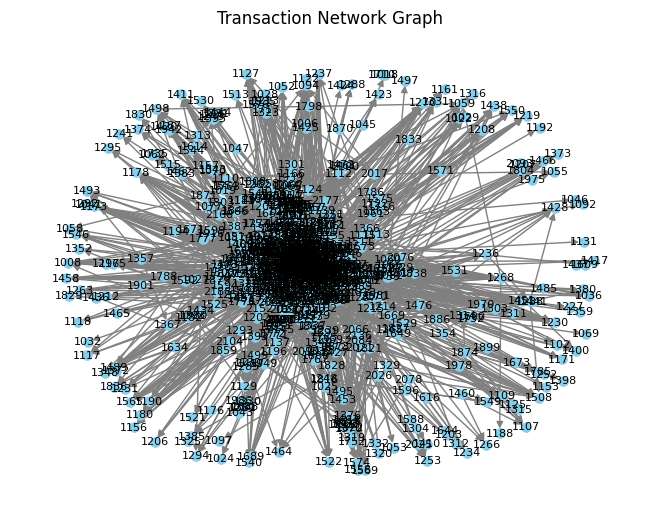

In [10]:
import networkx as nx

# Create a directed graph from sender-receiver relationships
G = nx.from_pandas_edgelist(data, source='Sender', target='Receiver', create_using=nx.DiGraph())
nx.draw(G, with_labels=True, node_size=50, font_size=8, node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title('Transaction Network Graph')
plt.show()


Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 0, Loss: 2.184102773666382
Epoch 10, Loss: 1.3246288299560547
Epoch 20, Loss: 1.296248197555542
Epoch 30, Loss: 1.203694462776184
Epoch 40, Loss: 1.183740496635437
Epoch 50, Loss: 1.1549524068832397
Epoch 60, Loss: 1.1398371458053589
Epoch 70, Loss: 1.1217896938323975
Epoch 80, Loss: 1.1080454587936401
Epoch 90, Loss: 1.089503526687622
KMeans Silhouette Score: 0.067205496
Spectral Silhouette Score: 0.0680764
GCN Silhouette Score: 0.13472264


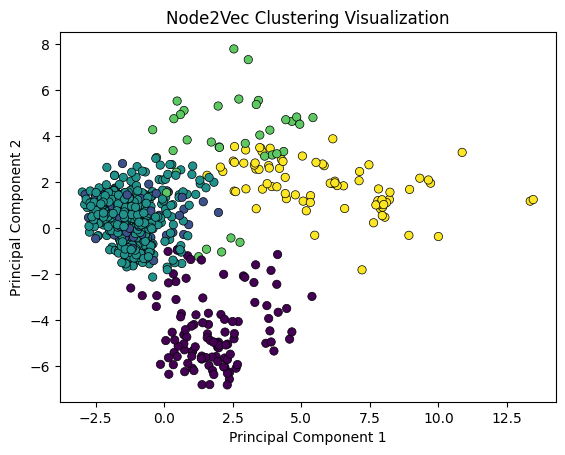

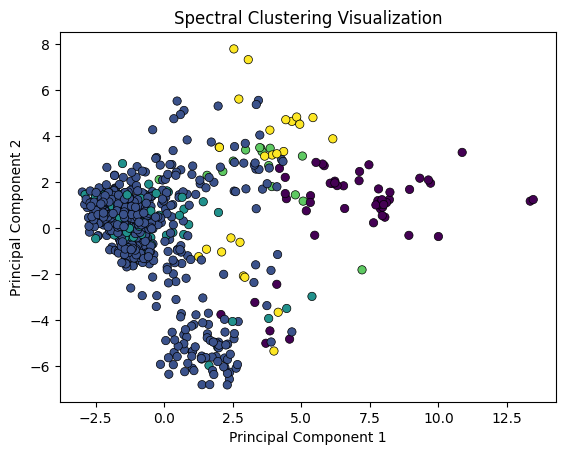

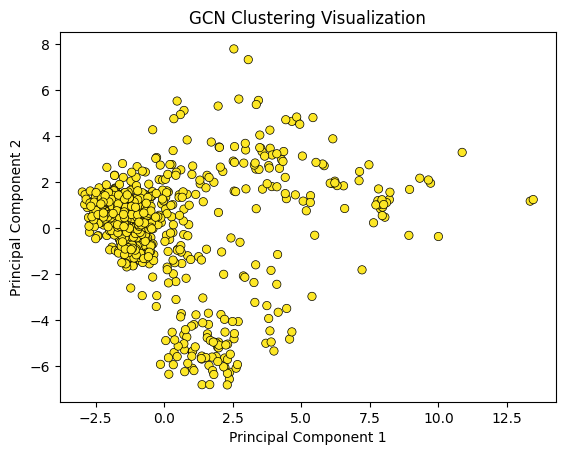

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from node2vec import Node2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

data = pd.read_csv('Payments.csv')
G = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', edge_attr='Amount', create_using=nx.DiGraph())

# Calculate the Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embeddings
embedding_matrix = [model.wv[key] for key in model.wv.key_to_index]
embeddings = np.array(embedding_matrix)

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_assignments_kmeans = kmeans.fit_predict(scaled_embeddings)

# Perform Spectral clustering
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
cluster_assignments_spectral = spectral.fit_predict(scaled_embeddings)

# Basic GCN implementation
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = F.relu(torch.sparse.mm(adj, x))
        x = F.dropout(x, training=self.training)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

# Convert adjacency matrix to a sparse matrix
adj_matrix_sparse = nx.convert_matrix.to_scipy_sparse_array(G)
adj_matrix_tensor = torch.tensor(adj_matrix_sparse.toarray(), dtype=torch.float32)

# Define GCN model
gcn_model = GCN(input_dim=embeddings.shape[1], hidden_dim=32, output_dim=5)

# Define optimizer and loss function
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Define function for early stopping
def train_gcn(adj_matrix, feature_matrix, model, optimizer, criterion, epochs=100, patience=5):
    model.train()
    best_loss = float('inf')
    wait = 0
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(feature_matrix, adj_matrix)
        loss = criterion(output, torch.tensor(cluster_assignments_kmeans, dtype=torch.long))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        if loss < best_loss:
            best_loss = loss
            wait = 0
        else:
            wait += 1
            if wait > patience:
                print('Early stopping at epoch {}'.format(epoch))
                break

# Train GCN with early stopping
train_gcn(adj_matrix_tensor, torch.tensor(scaled_embeddings, dtype=torch.float32), gcn_model, optimizer, criterion, epochs=100, patience=10)

# Get GCN clusters
with torch.no_grad():
    gcn_model.eval()
    gcn_output = gcn_model(torch.tensor(scaled_embeddings, dtype=torch.float32), adj_matrix_tensor)
    cluster_assignments_gcn = torch.argmax(gcn_output, dim=1).numpy()

# Calculate silhouette scores
score_kmeans = silhouette_score(scaled_embeddings, cluster_assignments_kmeans)
score_spectral = silhouette_score(scaled_embeddings, cluster_assignments_spectral)
score_gcn = silhouette_score(scaled_embeddings, cluster_assignments_gcn)

print("KMeans Silhouette Score:", score_kmeans)
print("Spectral Silhouette Score:", score_spectral)
print("GCN Silhouette Score:", score_gcn)

# Visualize the clusters for Node2Vec
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_embeddings)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_assignments_kmeans,edgecolors='black', linewidths=0.5)
plt.title("Node2Vec Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Visualize the clusters for Spectral clustering
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_assignments_spectral,edgecolors='black', linewidths=0.5)
plt.title("Spectral Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Visualize the clusters for GCN
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_assignments_gcn,edgecolors='black', linewidths=0.5)
plt.title("GCN Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


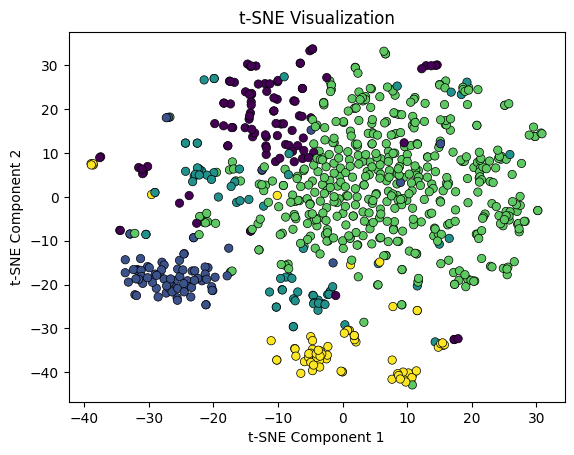

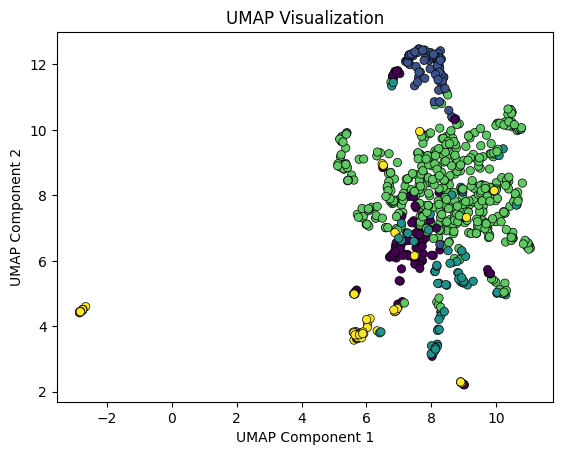

In [4]:
from sklearn.manifold import TSNE
from umap import UMAP

# Reduce dimensionality with UMAP
umap_model = UMAP(n_components=2)
umap_embeddings = umap_model.fit_transform(scaled_embeddings)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(scaled_embeddings)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_assignments_kmeans, edgecolors='black', linewidths=0.5)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_assignments_kmeans, edgecolors='black', linewidths=0.5)
plt.title("UMAP Visualization")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


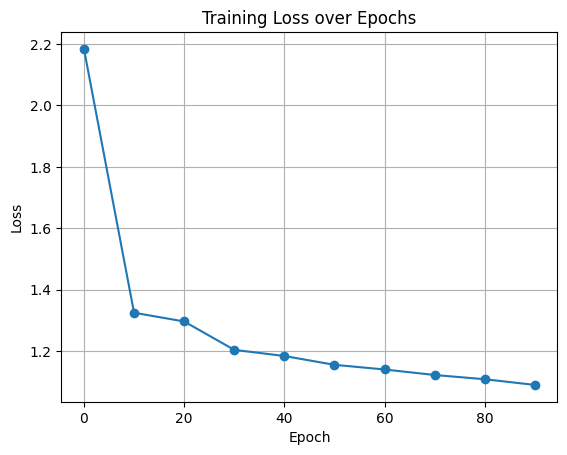

In [7]:
import matplotlib.pyplot as plt

# Training loss values
epochs = range(0, 91, 10) 
loss_values = [2.184102773666382, 1.3246288299560547, 1.296248197555542, 1.203694462776184, 
               1.183740496635437, 1.1549524068832397, 1.1398371458053589, 1.1217896938323975, 
               1.1080454587936401, 1.089503526687622]

# Plot training loss
plt.plot(epochs, loss_values, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
